# Summary

This is a little python project. 
I'll gather data using GuardianAPI and train NLP model for news classification using headlines and Tensorflow.

## Tools:
* GuardianAPI for gathering data
* Numpy 
* Pandas
* Matplotlib 
* Tensorflow

## Stages:

* Gather data
* Explore data
* Clean data
* Preprocess data
* Prepare a model
* Try it out

### Gathering data

We have to import needed tools first

In [1]:
import os
import glob
import json
import requests
import pandas as pd
import numpy as np
import re 
import seaborn as sns
import tensorflow as tf
from datetime import datetime, date, timedelta
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
STOPWORDS = set(stopwords.words('english'))

Let's make a list of sections our news are divided into.

In [ ]:
url_get_sections=('https://content.guardianapis.com/sections?api-key=test')
sections=[]
response = requests.get(url_get_sections).json()
for i in response['response']['results']:
    if i['id'] not in sections:
        sections.append(i['id'])
 

There will be a lot of .csv so creating a directory for them is a goor idea

In [ ]:
os.mkdir('csv') 

We have to scroll through pages of data Guardian sends to us since API only gives limited number of news per page.
And every time we have to use url so let's define a function for this to keep code readable.

In [ ]:
def fetching(section, from_date = '2010-01-01', to_date='2022-01-01', page = '1'):
    """
    Dates shoud have YYY-MM-DD format
    """
    url_fetch =('https://content.guardianapis.com/search?'
       f'section={section}'
       '&page-size=200'
       f'&from-date={from_date}' 
       f'&to-date={to_date}'
       f'&page={page}'
       '&api-key=1e948509-ec9c-445a-904c-ba1e0be974ca')
    return url_fetch

So now we choose period at which we gather data and check if end date is greater than start date.

In [ ]:
from_date ='2000-01-01'
to_date = '2022-01-01'

if ((datetime.strptime(to_date,'%Y-%m-%d').date()-datetime.strptime(from_date,'%Y-%m-%d').date()).days)<=0 :
    raise Exception("to_date must be greater than from_date")
  

I decided to gather one section of news at a time since there were news without any section assigned.
Also API can't manage to give us more than ~38k news records so we have to adapt to limitations.
It is highly unlikely for section to have more than 38k news in 12 months so we'll gather 12 months at a time from start date to end date.
Also I left date as a data just in case if I'll use it later for some visualisation.

In [ ]:
for section in sections:                                       # Collecting data for each section 
    df = pd.DataFrame(columns=['Date','Content','Section'])
    start_date = datetime.strptime(from_date,'%Y-%m-%d').date()
    end_date = datetime.strptime(to_date,'%Y-%m-%d').date()
    while True:                                                # Iterating through years
        if int((end_date - start_date).days) >365:             
            mid_date = start_date + timedelta(365)
        else:
            mid_date = end_date
            
        url = fetching(section, str(start_date), str(mid_date))
        response = requests.get(url).json()['response']
        pages = response['pages']
        for page in range(1,pages+1):                          # Iterating through pages
            url = fetching(section, str(start_date), str(mid_date), str(page))
            response=requests.get(url).json()['response']
            for i in range(0,len(response['results'])):        # Here we'll save data from page to df
                adding_row=[response['results'][i]['webPublicationDate'][:10],
                            response['results'][i]['webTitle'], response['results'][i]['sectionId']]
                df.loc[len(df)] = adding_row
        start_date = mid_date + timedelta(1)                   # API includes last date while gathering 
                                                               # so we flip starting day onto the next one
        if int((end_date - start_date).days) <= 0:             
            break
                           
    df.to_csv(f'csv\\{re.sub("[/-]","_",section)}.csv')         # Saving df with section as .csv replacing "/" and "-" with "_"
print('\n', df.shape)


I saved each section by itself just in case I would like to do something with them later and combined all sections in combined_csv. 
And that's all for gathering data. Let's move on to dataframe itself.

In [4]:
all_filenames = [i for i in glob.glob('csv\\*.csv')]
df = pd.concat([pd.read_csv(f) for f in all_filenames ])
df.to_csv( "csv\\combined_csv.csv", index=False, encoding='utf-8')


## Exploring data

So let's see if everything is ok and create a dataframe from .csv

In [12]:
df = pd.read_csv("csv\\combined_csv.csv")
df.head()

,Unnamed: 0,Date,Content,Section
0,0,2017-03-17,Contact the Guardian securely,about
1,1,2018-01-09,A letter from the editor-in-chief on the new G...,about
2,2,2021-04-30,Guardian and Observer style guide: A,about
3,0,2018-12-10,"Animals farmed: carbon footprints, farm violen...",animals-farmed
4,1,2018-11-07,"Animals farmed: swine fever, chick culling and...",animals-farmed


Now let's get rid of columns we will not need and see what we have left.

In [13]:
df = df.drop(["Date","Unnamed: 0"], axis = 1)
df.shape

(1634790, 2)

Looking at the histogram below we see that there is plenty of sections and not all of them are large enough or even make sence as a separate unit.

There are 71 news categories


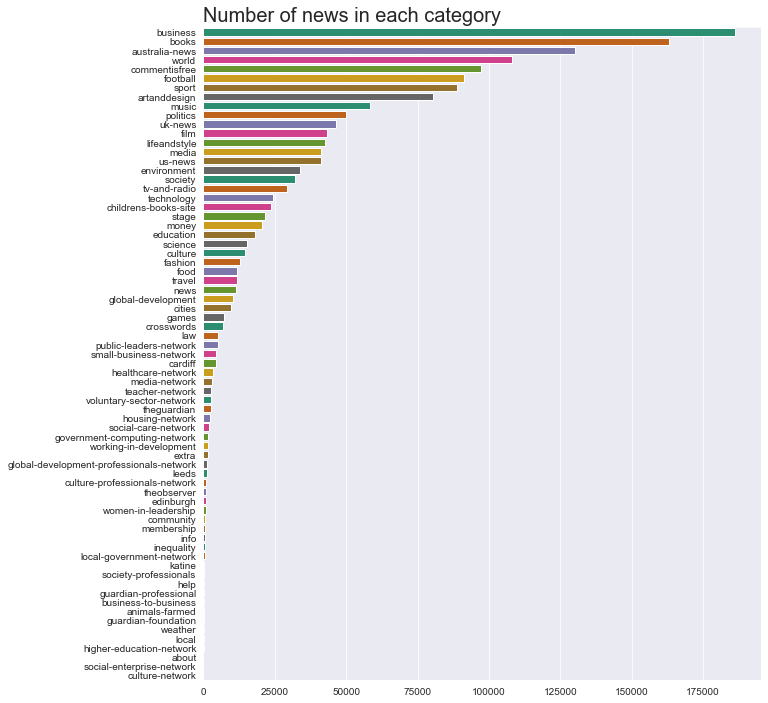

In [14]:
count_df = pd.DataFrame(df['Section'].value_counts()).reset_index()
print('There are', len(count_df), 'news categories')

def frequency_histogram(df, y_axis, x_axis):
    sns.set_style('darkgrid')
    plt.figure(figsize=(10, 12))
    sns.barplot(data=df, y=y_axis, x=x_axis, palette='Dark2')
    plt.title('Number of news in each category', loc='left', fontsize=20)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()
    
frequency_histogram(count_df, 'index', 'Section')


Manualy looking through data I noticed that we can merge a lot of categories here since they resemple pretty much the same thing.
Also there are sections without actual news but with some articles about Guardian itself so I'd rather delete them.

In [15]:
categories_to_merge_dict = {
    'world': ['uk-news', 'us-news', 'australia-newsm', 'theguardian', 'theobserver'],
    'books': ['childrens-books-site'],
    'business': ['small-business-network', 'business-to-business', 'social-enterprise-network'],
    'local': ['cardiff', 'katine edinburgh', 'leeds', 'local-government-network', 'edinburgh', 'katine'],
    'education': ['higher-education-network', 'teacher-network'],
    'society': ['society-professionals', 'inequality'],
    'extra': ['help'],
    'global-development':['global-development-professionals-network'],
    'environment':['animals-farmed'],
    'membership': ['guardian-professional', 'guardian-foundation', 'guardian'],
    'culture':['culture-professionals-network'],
    'technology': ['info'],
    'working-networks':['government-computing-network','social-care-network','housing-network', 'voluntary-sector-network',
               'media-network', 'healthcare-network', 'public-leaders-network'],
    'news':['weather']}

def merging_categories(dataframe,dict_of_categories):
    for k,v in dict_of_categories.items():
        dataframe.loc[dataframe['Section'].isin(v), 'Section'] = k

merging_categories(df,categories_to_merge_dict)

drop_list = ['about', 'culture-network']
    
df = df.drop(df[df['Section'].isin(drop_list)].index)


We have a lot less sections now.

In [16]:
df.Section.nunique()

38

Now we delete stopwords and lowercase everything

In [17]:
def get_rid_of_non_words(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text) #delete everything that is not a letter/number/whitespace

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.lower() not in STOPWORDS:
            final_text.append(i)
    return " ".join(final_text)

df['Content'] = df['Content'].str.lower()
df['Content'] = df['Content'].apply(get_rid_of_non_words)
df['Content'] = df['Content'].apply(remove_stopwords)


Updated histogram

There are 38 news categories


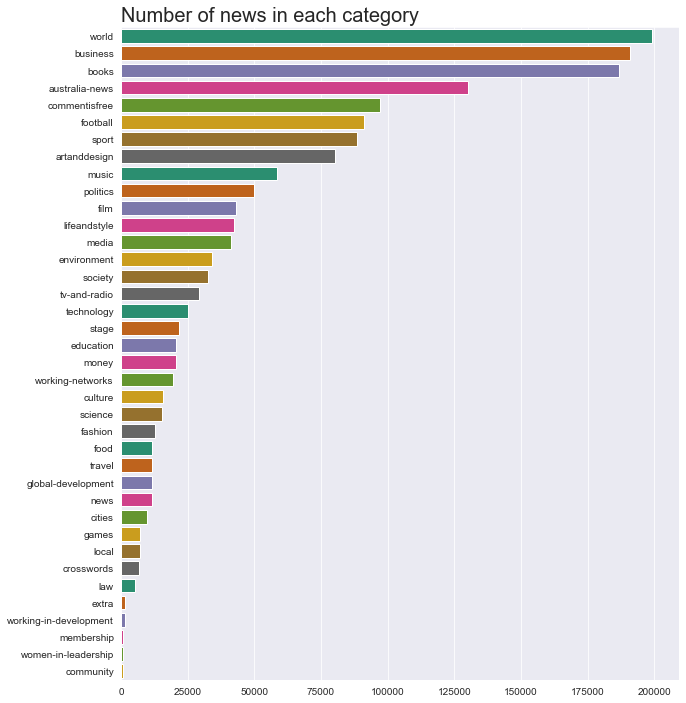

In [18]:
count_df = pd.DataFrame(df['Section'].value_counts()).reset_index()
print('There are', len(count_df), 'news categories')

def frequency_histogram(df, y_axis, x_axis):
    sns.set_style('darkgrid')
    plt.figure(figsize=(10, 12))
    sns.barplot(data=df, y=y_axis, x=x_axis, palette='Dark2')
    plt.title('Number of news in each category', loc='left', fontsize=20)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()
    
frequency_histogram(count_df, 'index', 'Section')


As we see data is imbalanced so I'll use undersampling.
I'll take length of the smallest Section as a baseline for samplimng.

In [33]:

smallest_section_len = df.groupby(['Section']).size().sort_values()[0]

def undersampling_df(dataframe, sample_length):
    dfs = []
    for section in dataframe['Section'].unique():
        temp = dataframe[dataframe['Section']==section]
        dfs.append(temp.sample(sample_length))

    dataframe = pd.concat(dfs)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    return dataframe

df = undersampling_df(df, smallest_section_len)


In [34]:
df.shape

(24092, 2)

Our data is ready and now we have to build a model.
Starting with encoding labels and splitting data into train and validation sets.

In [35]:
headlines = np.array([headline for headline in df['Content']])
labels = np.array([label for label in df['Section']])

labels = LabelEncoder().fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(headlines, labels, test_size = 0.2, 
random_state = 0, shuffle = True)


Parameters needed for tokenizing and embedding layer.

In [36]:
vocab_size = 20000 # the average active vocabulary of an adult English speaker
embedding_dim = 64
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


Tokenizing headlines.

In [37]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

Convert train and validation dataset to sequence and padding these sequencess.

In [38]:
train_sequences = tokenizer.texts_to_sequences(X_train)
max_length = len(max(train_sequences, key=len))
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

Compiling a model.

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(38, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 27, 64)            1280000   
                                                                 
 conv1d_3 (Conv1D)           (None, 23, 128)           41088     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 24)                3096      
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_6 (Dense)             (None, 38)                950       
                                                      

Let's finally see what it does.

In [44]:
num_epochs = 10
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2)

Epoch 1/10
482/482 - 24s - loss: 3.2544 - accuracy: 0.1470 - val_loss: 2.6959 - val_accuracy: 0.2926 - 24s/epoch - 50ms/step
Epoch 2/10
482/482 - 21s - loss: 2.1266 - accuracy: 0.4385 - val_loss: 2.2503 - val_accuracy: 0.4477 - 21s/epoch - 43ms/step
Epoch 3/10
482/482 - 22s - loss: 1.1574 - accuracy: 0.6948 - val_loss: 2.3849 - val_accuracy: 0.4558 - 22s/epoch - 46ms/step
Epoch 4/10
482/482 - 21s - loss: 0.5740 - accuracy: 0.8521 - val_loss: 2.7253 - val_accuracy: 0.4558 - 21s/epoch - 44ms/step
Epoch 5/10
482/482 - 22s - loss: 0.3080 - accuracy: 0.9215 - val_loss: 3.0929 - val_accuracy: 0.4472 - 22s/epoch - 46ms/step
Epoch 6/10
482/482 - 21s - loss: 0.1840 - accuracy: 0.9521 - val_loss: 3.5101 - val_accuracy: 0.4366 - 21s/epoch - 44ms/step
Epoch 7/10
482/482 - 22s - loss: 0.1273 - accuracy: 0.9676 - val_loss: 3.8266 - val_accuracy: 0.4420 - 22s/epoch - 46ms/step
Epoch 8/10
482/482 - 22s - loss: 0.0907 - accuracy: 0.9761 - val_loss: 4.2050 - val_accuracy: 0.4376 - 22s/epoch - 45ms/step


42% is not so bad for that simple model. Also undersampling takes its toll.

Some visualisation for loss and accuracy.
By the way I tried LSTM earlier and it showed slightly worse result giving 2%-3% less accuracy.

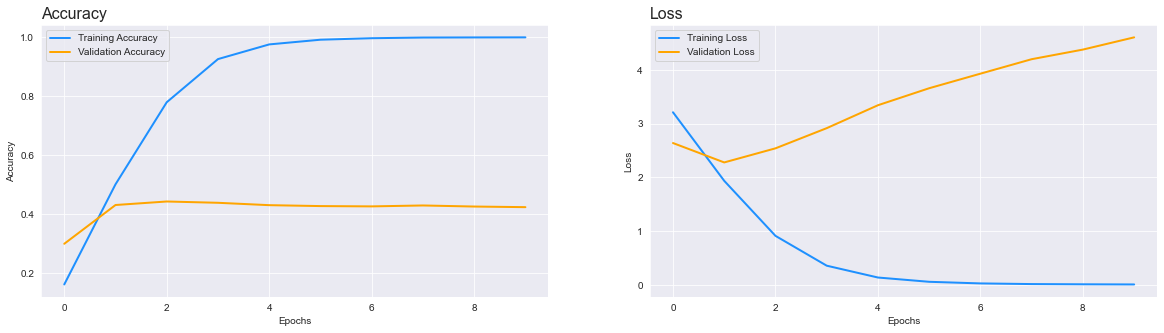

In [41]:
def plot_history(history):
    
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', c='dodgerblue', lw='2')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='orange', lw='2')
    plt.title('Accuracy', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', c='dodgerblue', lw='2')
    plt.plot(history.history['val_loss'], label='Validation Loss', c='orange', lw='2')
    plt.title('Loss', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
plot_history(history)

What is going on with loss increase? 

Note that when one uses cross-entropy loss for classification as it is usually done, bad predictions are penalized much more strongly than good predictions are rewarded. So even if many sections are correctly predicted, a single misclassified section will have a high loss, hence "blowing up" my mean loss. 


### What challenged me in this project.

* First of all, gathering data was not so easy because of API restrictions. 1.6kk of news is a lot and it took me a while to collect them without replecations or missing date.

* Secondly, cleaning data and merging sections was time-consuming and yet I still have an imbalansed dataset.

* Furthermore, amount of documentation and other materials on tensorflow is overwhelming. It was not easy to even understand that number of dimensions of last layer must be the same as number of categories I place headlines on, although now it is obvious. I'd say building a model a bit more complex than for binary classification is way less user-friendly than you can expect looking for Sentimental Classification on YouTube.

### What will I do later?

This is still just a raw project with a lot of work to do in future:

* Balance out the dataset using something like SMOTE or synthesize new data by myself using most common words for each section.

* Add bigrams and trigrams

* Also for more accurate loss on imbalanced dataset we could use logloss.